In [1]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar
from datetime import date
import yaml
import io
import json
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

%matplotlib inline

/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1685: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<=lonen4.values)&(lonen4.values<lonmax)&(latmin<=laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                for ref in np.arange(len(indz[0])):
                    dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                    ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                    tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                    if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                        prof_zone.append(indz[0][ref])
                        tsecen4z.append(tsecen4)

                nb_profiles=nb_profiles+len(prof_zone)
        return nb_profiles


In [3]:
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb_profiles_NATL60_1year=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb_profiles_NATL60_1year


90544.0


In [124]:
#quadrillage tous les 0.5째

Xbox=(lonmax-lonmin+1)/0.5
Ybox=(latmax-latmin+1)/0.5

nb_prof_box05_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+0.5*j
        lat2=latmin+0.5*(j+1.)
        lon1=lonmin+0.5*i
        lon2=lonmin+0.5*(i+1.)
        nb=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
        nb_prof_box05_1year[i,j,0]=nb
        nb_prof_box05_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box05_1year[i,j,2]=0.5*(lon1+lon2)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [125]:
nb_prof_box05_1year.shape

(178, 68, 3)

In [126]:
np.nanmax(nb_prof_box05_1year[:,:,0])

4538.0

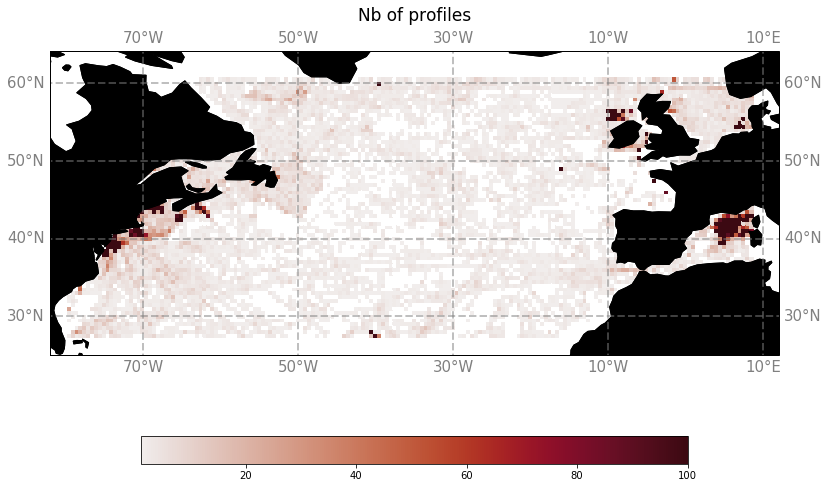

In [8]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1],nb_prof_box05_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=100)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage05.png")

In [89]:
idcent=np.where(nb_prof_box05_1year[:,:,0]>100)
idcent[0].shape

(102,)

In [52]:
def list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))

                prof_zone=[]
                tsecen4z=[]

                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                for ref in np.arange(len(prof_zone)):
                        list_reference.append(str(refen4[prof_zone[ref]].values))


        return list_reference


In [90]:
list_reference=[]

for k in np.arange(len(idcent[0])):
    latmin=nb_prof_box05_1year[idcent[0][k], idcent[1][k],1]-0.25
    latmax=nb_prof_box05_1year[idcent[0][k], idcent[1][k],1]+0.25
    lonmin=nb_prof_box05_1year[idcent[0][k], idcent[1][k],2]-0.25
    lonmax=nb_prof_box05_1year[idcent[0][k], idcent[1][k],2]+0.25
    datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
    list_reference=list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [91]:
len(list_reference)

60829

In [113]:
def select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<=lonen4.values)&(lonen4.values<lonmax)&(latmin<=laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                
                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                list_ref=[]
                for ref in np.arange(len(prof_zone)):
                        if not str(refen4[prof_zone[ref]].values) in list_reference:
                            list_ref.append(ref)

                nb_profiles=nb_profiles+len(list_ref)
        return nb_profiles


In [114]:
#quadrillage tous les 1째
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)
Ybox=(latmax-latmin+1)

nb_prof_box1_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+j
        lat2=latmin+(j+1.)
        lon1=lonmin+i
        lon2=lonmin+(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box1_1year[i,j,0]=nb
        nb_prof_box1_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box1_1year[i,j,2]=0.5*(lon1+lon2)


In [115]:
nb_prof_box1_1year.shape

(89, 34, 3)

In [116]:
print np.nanmax(nb_prof_box1_1year[:,:,0])


4279.0
44.5
-68.5


In [82]:
idcent=np.where(nb_prof_box1_1year[:,:,0]>100)
print len(idcent[0]),' boxes'
#for k in np.arange(len(idcent[0])):
#    print nb_prof_box1_1year[idcent[0][k],idcent[1][k],0],' profiles'
#    print 'lat = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],1]
#    print 'lon = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],2]


19  boxes


In [84]:
id1=np.where(nb_prof_box1_1year[:,:,0]>50)
print len(idcent[0]),' boxes with more than 50 profiles'
#for k in np.arange(len(idcent[0])):
#    print nb_prof_box1_1year[idcent[0][k],idcent[1][k],0],' profiles'
#    print 'lat = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],1]
#    print 'lon = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],2]


58  boxes with more than 50 profiles


In [85]:
def append_list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))

                prof_zone=[]
                tsecen4z=[]

                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                            if not str(refen4[indz[0][ref]].values) in list_reference:
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                for ref in np.arange(len(prof_zone)):
                        list_reference.append(str(refen4[prof_zone[ref]].values))


        return list_reference


In [86]:
#list_reference=[]
#append existing list_reference

for k in np.arange(len(id1[0])):
    latmin=nb_prof_box1_1year[id1[0][k], id1[1][k],1]-0.5
    latmax=nb_prof_box1_1year[id1[0][k], id1[1][k],1]+0.5
    lonmin=nb_prof_box1_1year[id1[0][k], id1[1][k],2]-0.5
    lonmax=nb_prof_box1_1year[id1[0][k], id1[1][k],2]+0.5
    datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
    list_reference=append_list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [88]:
len(list_reference)

66085

In [92]:
#quadrillage tous les 5째
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)/5
Ybox=(latmax-latmin+1)/5

nb_prof_box5_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+5*j
        lat2=latmin+5*(j+1.)
        lon1=lonmin+5*i
        lon2=lonmin+5*(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box5_1year[i,j,0]=nb
        nb_prof_box5_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box5_1year[i,j,2]=0.5*(lon1+lon2)


In [93]:
nb_prof_box5_1year.shape

(17, 6, 3)

In [94]:
17*6

102

In [95]:
print np.nanmax(nb_prof_box5_1year[:,:,0])

4873.0


In [106]:
print np.nanmax(nb_prof_box5_1year[:,:,0])
idmax=np.where(nb_prof_box5_1year[:,:,0]==np.nanmax(nb_prof_box5_1year[:,:,0]))

print 'lat =',nb_prof_box5_1year[idmax[0][0],idmax[1][0],1]
print 'lon =',nb_prof_box5_1year[idmax[0][0],idmax[1][0],2]


4873.0
lat = 44.5
lon = -67.5


In [107]:
latmin=43
latmax=47
lonmin=-70
lonmax=-65
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

17026.0
4594.0


In [97]:

idmax=np.where(nb_prof_box5_1year[:,:,0]==np.nanmax(nb_prof_box5_1year[:,:,0]))
print nb_prof_box5_1year[idmax[0][0],idmax[1][0],1]
print nb_prof_box5_1year[idmax[0][0],idmax[1][0],2]

44.5
-67.5


In [98]:
#quadrillage tous les 2째
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)/2
Ybox=(latmax-latmin+1)/2

nb_prof_box2_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+2*j
        lat2=latmin+2*(j+1.)
        lon1=lonmin+2*i
        lon2=lonmin+2*(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box2_1year[i,j,0]=nb
        nb_prof_box2_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box2_1year[i,j,2]=0.5*(lon1+lon2)


In [104]:
print np.nanmax(nb_prof_box2_1year[:,:,0])
idmax=np.where(nb_prof_box2_1year[:,:,0]==np.nanmax(nb_prof_box2_1year[:,:,0]))

print 'lat =',nb_prof_box2_1year[idmax[0][0],idmax[1][0],1]
print 'lon =',nb_prof_box2_1year[idmax[0][0],idmax[1][0],2]


4331.0
lat = 44.0
lon = -69.0


In [105]:
latmin=43
latmax=45
lonmin=-70
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

13821.0
4331.0


In [108]:
latmin=43
latmax=44
lonmin=-70
lonmax=-69
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '1er quart =',nbmax

latmin=43
latmax=44
lonmin=-69
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '2e quart =',nbmax

latmin=44
latmax=45
lonmin=-70
lonmax=-69
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '3e quart =',nbmax

latmin=44
latmax=45
lonmin=-69
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '4e quart =',nbmax

1er quart = 29.0
2e quart = 22.0
3e quart = 0.0
4e quart = 0.0


In [112]:

latmin=43.5
latmax=44.5
lonmin=-69.5
lonmax=-68.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

8636.0
4278.0


In [111]:
latmin=43.75
latmax=44.25
lonmin=-69.25
lonmax=-68.75
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax


4299.0
4278.0


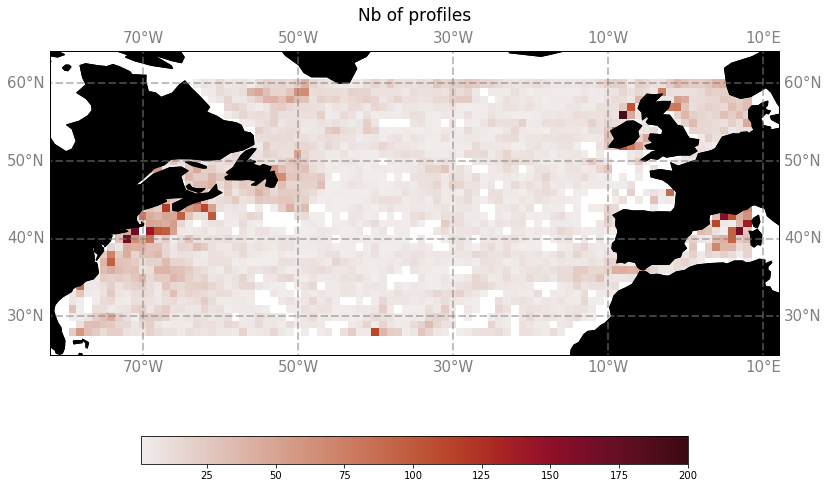

In [101]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box1_1year[:,:,2], nb_prof_box1_1year[:,:,1],nb_prof_box1_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=200)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage1.png")

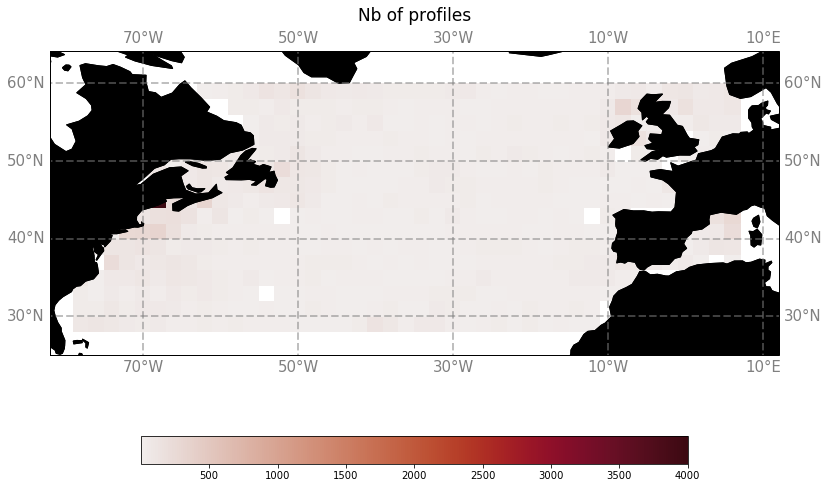

In [103]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box2_1year[:,:,2], nb_prof_box2_1year[:,:,1],nb_prof_box2_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=4000)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage2.png")